import modul

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Konfigurasi Visual
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

def print_status(message):
    print(f"[INFO] {message}")

DATA LOADING & PREPROCESSING

In [36]:
print_status("Memuat dataset...")
df = pd.read_csv('insurance.csv')

# Binning Target menjadi 4 Kategori
df['charges_group'] = pd.qcut(df['charges'], q=4, labels=['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi'])

# Encoding
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_target = LabelEncoder()

df['sex'] = le_sex.fit_transform(df['sex'])
df['smoker'] = le_smoker.fit_transform(df['smoker'])
df['charges_encoded'] = le_target.fit_transform(df['charges_group'])

# One-Hot Encoding Region
df = pd.get_dummies(df, columns=['region'], drop_first=True)

# Define X & y
X = df.drop(['charges', 'charges_group', 'charges_encoded'], axis=1)
y = df['charges_encoded']
feature_names = X.columns.tolist()

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling Imbalance (SMOTE)
print_status("Menyeimbangkan data training dengan SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

[INFO] Memuat dataset...
[INFO] Menyeimbangkan data training dengan SMOTE...


MODELING

[INFO] Melatih Decision Tree Classifier...

🏆 Akurasi Model: 85.82%


/tmp/ipython-input-3003894193.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette='viridis')


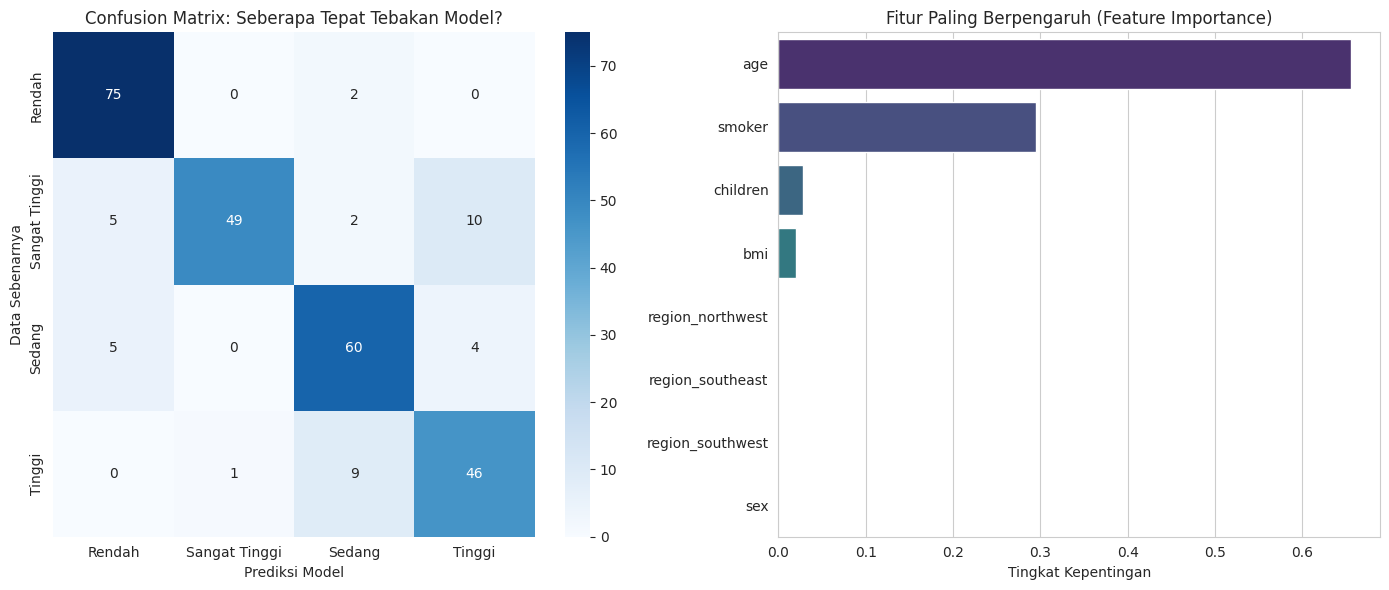

[INFO] Menggambar struktur pohon...


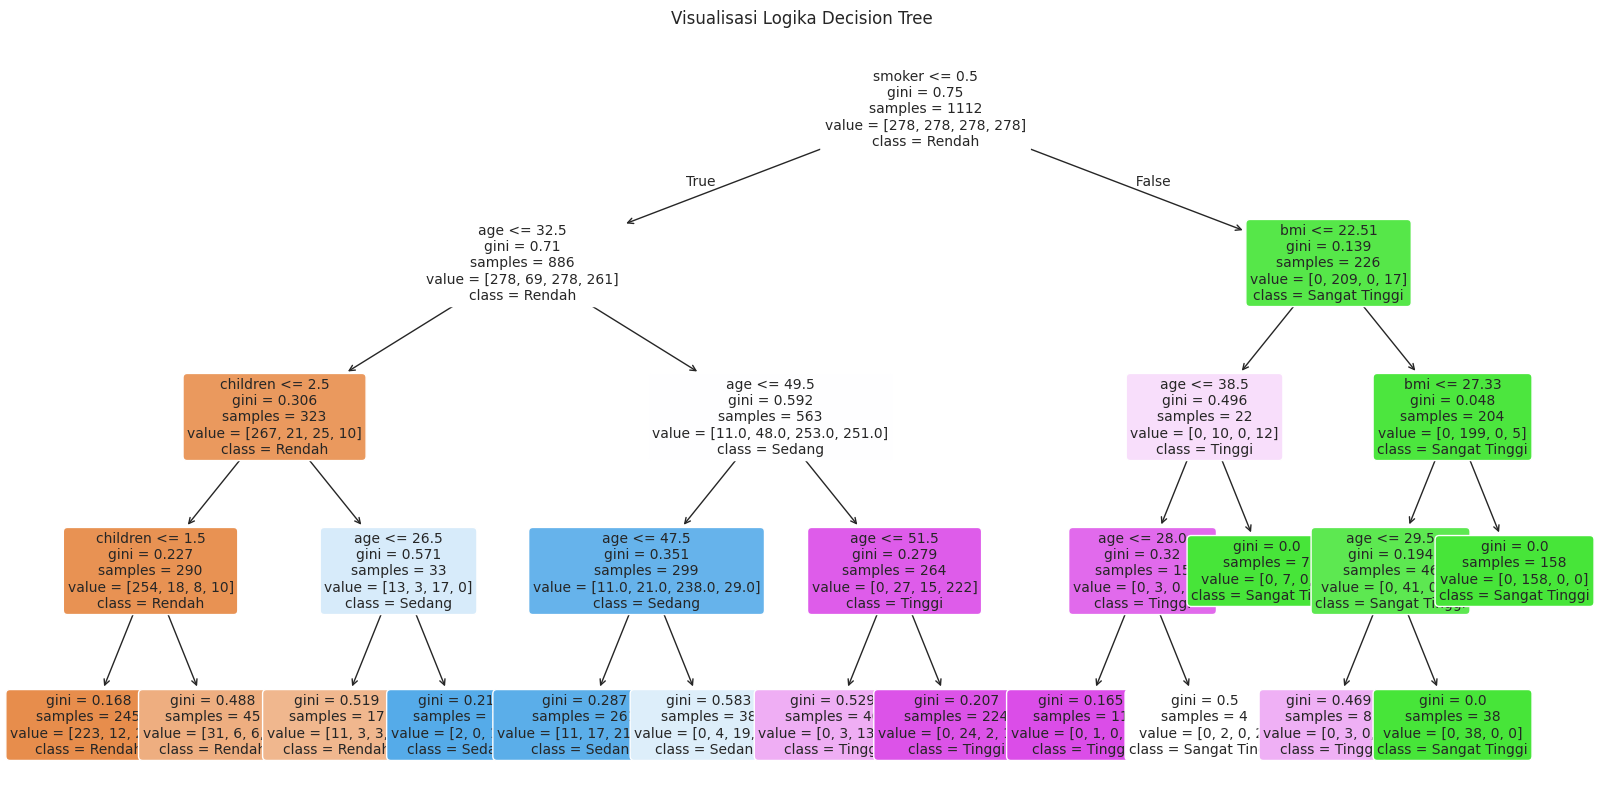

In [37]:
print_status("Melatih Decision Tree Classifier...")
# max_depth=4 agar pohon mudah dibaca manusia & mencegah overfitting
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

# ==========================================
# 3. EVALUASI & VISUALISASI LENGKAP
# ==========================================
y_pred = dt_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n🏆 Akurasi Model: {acc * 100:.2f}%")

# --- Visual 1: Confusion Matrix ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix: Seberapa Tepat Tebakan Model?')
plt.ylabel('Data Sebenarnya')
plt.xlabel('Prediksi Model')

# --- Visual 2: Feature Importance (PENTING) ---
# Melihat fitur mana yang paling menentukan harga
plt.subplot(1, 2, 2)
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette='viridis')
plt.title('Fitur Paling Berpengaruh (Feature Importance)')
plt.xlabel('Tingkat Kepentingan')
plt.tight_layout()
plt.show()

# --- Visual 3: Pohon Keputusan ---
print_status("Menggambar struktur pohon...")
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=feature_names, class_names=le_target.classes_,
          filled=True, rounded=True, fontsize=10)
plt.title("Visualisasi Logika Decision Tree")
plt.show()

INTERACTIVE USER INPUT

In [38]:
def run_interactive_prediction():
    print("\n" + "="*50)
    print("🌲 PROGRAM PREDIKSI ASURANSI (DECISION TREE)")
    print("="*50)

    while True:
        try:
            print("\n--- Masukkan Data Pasien ---")
            age = int(input("Usia\t\t: "))
            bmi = float(input("BMI\t\t: "))
            children = int(input("Jumlah Anak\t: "))

            sex = input("Gender (male/female): ").lower()
            if sex not in ['male', 'female']: raise ValueError("Gender salah.")

            smoker = input("Perokok (yes/no)\t: ").lower()
            if smoker not in ['yes', 'no']: raise ValueError("Status perokok salah.")

            region = input("Wilayah (northeast/northwest/southeast/southwest): ").lower()
            if region not in ['northeast', 'northwest', 'southeast', 'southwest']: raise ValueError("Wilayah salah.")

            # Prepare Data Frame
            input_df = pd.DataFrame(np.zeros((1, len(feature_names))), columns=feature_names)
            input_df['age'] = age
            input_df['bmi'] = bmi
            input_df['children'] = children
            input_df['sex'] = le_sex.transform([sex])[0]
            input_df['smoker'] = le_smoker.transform([smoker])[0]

            # Region Handling
            if region == 'northwest': input_df['region_northwest'] = 1
            elif region == 'southeast': input_df['region_southeast'] = 1
            elif region == 'southwest': input_df['region_southwest'] = 1

            # Predict
            pred_idx = dt_model.predict(input_df)[0]
            result = le_target.inverse_transform([pred_idx])[0]

            print("-" * 40)
            print(f"💡 HASIL: Biaya Asuransi -> {result.upper()}")
            print("-" * 40)

        except ValueError as e:
            print(f"❌ Error: {e}. Harap input dengan benar.")
        except Exception as e:
            print(f"❌ Terjadi kesalahan sistem: {e}")

        if input("\nHitung lagi? (y/n): ").lower() != 'y':
            break

# Jalankan program input
run_interactive_prediction()


🌲 PROGRAM PREDIKSI ASURANSI (DECISION TREE)

--- Masukkan Data Pasien ---
Usia		: 20
BMI		: 25.5
Jumlah Anak	: 2
Gender (male/female): male
Perokok (yes/no)	: no
Wilayah (northeast/northwest/southeast/southwest): northwest
----------------------------------------
💡 HASIL: Biaya Asuransi -> RENDAH
----------------------------------------

Hitung lagi? (y/n): n
